## Prototype code for the video sensor sync project

This program will process the accelerometer sensor data to calculate the magnitude of change of acceleration.

Then, video data will be processed to calculate the changes by frame.

Finally, cross-correaltion analysis will be performed on both signals and the lag will be identified.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
import VidAccSyn
#from google.colab import files

Upload the files separately for processing

Currently expecting a .csv file for sensor and .mp4 file for video

Cross correlation will be performed to identify the lag between the signals

Upload the sensor data file first

# Sensor data processing

In [2]:
#uploaded_sensor = files.upload()

In [3]:
#Retrieves the filename of the uploaded file
#sensor_filename = next(iter(uploaded_sensor))
#print(sensor_filename)

In [4]:
#Arlene wrote this part. Modified to use as a function
def process_sensor_data(filename, fieldnames):
  df_raw = pd.read_csv(filename)

  #expand the fieldnames from the input
  x_field, y_field, z_field = fieldnames

  delta_x = df_raw[x_field].diff().dropna()
  delta_y = df_raw[y_field].diff().dropna()
  delta_z = df_raw[z_field].diff().dropna()

  mag_changes_res = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z **2 )

  #shows the changes
  plt.figure(figsize=(12, 4))
  plt.subplot(2, 1, 1)
  plt.plot(mag_changes_res, label='Sensor')
  #plt.plot(signal2, label='Signal 2')
  plt.legend()
  plt.show()

  return mag_changes_res

Process the sensor data file and show the magnitude of changes

Field names are defined here and passed into the function. The field names may be different on the actual data and will need to be modified here.

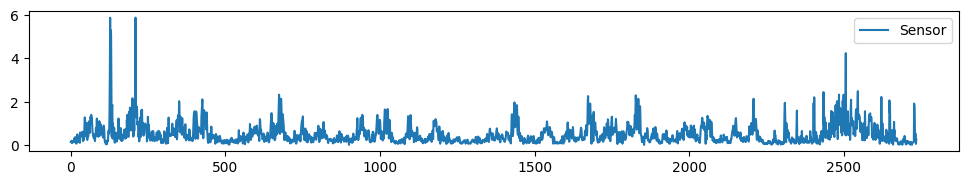

In [5]:
fieldnames =  'Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)'
processed_sensor_data = process_sensor_data("walk.csv", fieldnames)

# Video file processing

The video_to_graph function reads in a video, calculates the difference between frames, and plots of graph of the differences.

In [6]:
#Code by Usha to process the video and calculate the difference between frames
def video_to_graph(video_path, threshold=30):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame
    ret, prev_frame = cap.read()
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    frame_diffs = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate absolute difference between frames
        flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        average_flow_magnitude = np.mean(mag)

        frame_diffs.append(average_flow_magnitude)

        # Update the previous frame
        prev_frame_gray = frame_gray

    cap.release()

    frame_diffs = np.abs(np.gradient(frame_diffs)) #Gets the derivative

    # Plot the graph
    plt.plot(frame_diffs)
    ##plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.xlabel('Frame')
    plt.ylabel('Frame Difference')
    plt.title('Video Frame Differences')
    #plt.legend()
    plt.show()

    return frame_diffs


In [7]:
#video file. takes a while longer to upload since video files are larger
#uploaded_video = files.upload()

In [8]:
#Retrieves the filename of the uploaded file
video_filename = "walk.mp4" #next(iter(uploaded_video))
#print(video_filename)

{'path': 'walk.mp4'}
< cv2.VideoCapture 0000024EA8DF2A10>


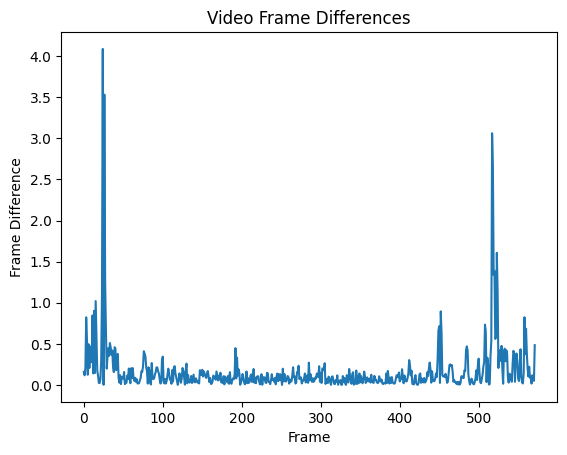

In [9]:
frame_diff = VidAccSyn.stdev_video_to_velocity(path=video_filename)
frame_diff = VidAccSyn.velocity_to_acceleration(frame_diff)

# Plot the graph
plt.plot(frame_diff)
##plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Frame')
plt.ylabel('Frame Difference')
plt.title('Video Frame Differences')
#plt.legend()
plt.show()

# Resampling

This is to ensure that both signals are of the same frequency to perform cross-correlation analysis

In [10]:
#resample both signals using the scipy.signal.resample function
#use the longer signal (sensor) as the length
max_len = max(len(processed_sensor_data), len(frame_diff))
resample_size = max_len
signal_rs = scipy.signal.resample(processed_sensor_data, resample_size)
video_rs = scipy.signal.resample(frame_diff, resample_size)


# Cross-correlation Analysis

Perform cross correlation analysis and show the results.

In [11]:
#code by Usha using cross correlation and finding the lag value. Updated to be a function.
def cross_correlation_analysis(signal1, signal2, labels):
  #cross-correlation
  #cross_correlation = np.correlate(signal1, signal2, mode='full')
  cross_correlation = scipy.signal.correlate(signal1, signal2, mode='full')

  # lag values
  lags = np.arange((-1* resample_size) +1, resample_size)

  # Plot the original signals
  fig, ax1 = plt.subplots()
  ax1.set_xlabel('time (ms)')
  ax1.set_ylabel('Changes in acceleration', color = 'tab:red')
  ax1.plot(signal1, label = labels[0], color = 'tab:red')
  ax2 = ax1.twinx()

  ax2.set_ylabel('Changes by frame', color = 'tab:blue')
  ax2.plot(signal2, label = labels[1], color = 'tab:blue')

  fig.tight_layout()
  plt.show()

  #plt.figure(figsize=(12, 4))
  #plt.subplot(2, 1, 1)
  #plt.plot(signal1, label= labels[0])
  #plt.plot(signal2, label= labels[1])
  #plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(lags, cross_correlation)
  plt.title('Cross-correlation')
  plt.xlabel('Lag')
  plt.ylabel('Correlation')

  # Show the plots
  plt.tight_layout()
  plt.show()
  return cross_correlation

# Results

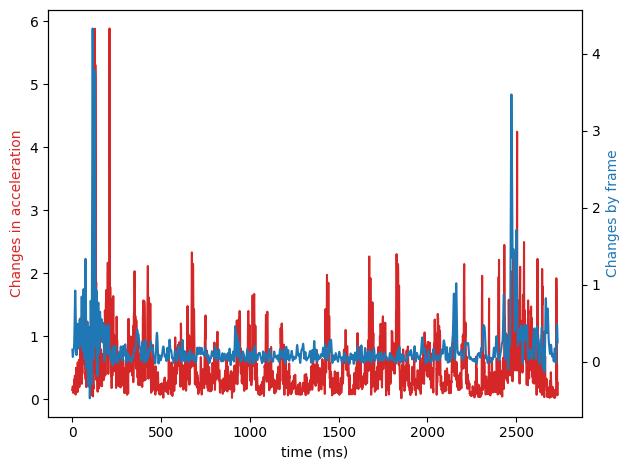

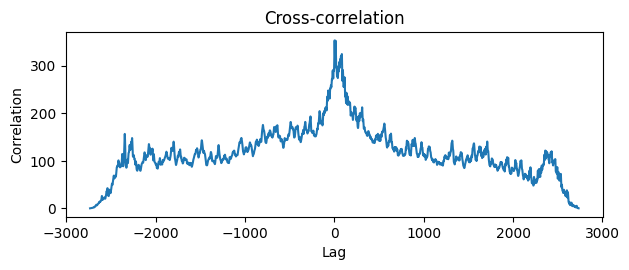

In [12]:
cc = cross_correlation_analysis(signal_rs, video_rs, ['sensor', 'video'])

In [13]:
list_cc = list(cc)
#print(max(list_cc))
#print(list_cc.index(max(list_cc)))
max_pos = list_cc.index(max(list_cc))
lag = max_pos - resample_size
print(f'lag at the max correlation is: {lag} (ms)')

lag at the max correlation is: 2 (ms)
